In [1]:
#!/opt/conda/envs/lae2020/bin/python3

from importlib.abc import Loader
import sys
import os
import ruamel.yaml

sys.path.insert(0,"/home/chinahg/GCresearch/cantera/build/python")
sys.path.insert(1,"/home/chinahg/GCresearch/rocketemissions")

import cantera as ct
ct.add_directory('/user/chinahg')
ct.__file__

import importlib
import h5py
import numpy as np
import time
import math as math
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
import yaml
import shutil
from scipy import integrate
import matplotlib.pyplot as plt
import Analytical_Plume_fxns as ap
importlib.reload(ap)

<module 'Analytical_Plume_fxns' from '/home/chinahg/GCresearch/rocketemissions/Analytical_Plume_fxns.py'>

In [2]:
## CONSTANTS
nx_ZFE = 100 # number of steps to take in the x direction for the zone of flow establishment
nx_ZEF = 100 # number of steps to take in the x direction for the zone of established flow
nx_tot = nx_ZEF+nx_ZFE # Total number of axial steps
nr = 100000 # number of steps to take in the radial direction for all zones

D = 2.90 # [m] Initial plume diameter (ZFE)
xmax_ZFE = 6.2*D # [m] Axial domain ZFE
xmax_ZEF = 200 # [m] Axial domain for ZEF

beta_ZFE = 0.114 # Diffusion coefficient
lmbda_ZFE = 1.2 # Mixing coefficient
lmbda_ZEF = 1.35 # Mixing coefficient
beta_ZEF = 0.154 # Diffusion coefficient

## IMPORTED CONDITIONS
T0 = 1800 # [K] Initial plume temperature NEED TO UPDATE
u_ZFE0 = 1500 # [m/s] Rocket velocity (need to import)
c_ZFE0 = 600000 # [mol/mol] Tracer ppm test
U_a = 428 # [m/s] Ambient velocity (need to import)
T_a = 400 # Ambient temperature [K] replace must import

## INITIALIZING ARRAYS
u_ZFE = np.zeros((nx_ZFE,nr)) # Velocity array for ZFE domain
c_ZFE = np.zeros((nx_ZFE,nr)) # Concentration array for ZFE domain

u_ZEF = np.zeros((nx_ZEF,nr)) # Velocity array for ZEF domain
c_ZEF = np.zeros((nx_ZEF,nr)) # Concentration array for ZEF domain

r_ZFE = np.zeros((nx_ZFE,nr)) # Radial sampling points, for each x. For x = 1 sample points from r = 0 to r = b[i]
x_ZFE = np.linspace(0,xmax_ZFE,nx_ZFE) # Axial sampling points

r_ZEF = np.zeros((nx_ZEF,nr))
x_ZEF = np.linspace(xmax_ZFE,xmax_ZEF,nx_ZEF)

A_c = c_ZFE0*(D/2) #step fxn area
A_u = u_ZFE0*(D/2) #step fxn area

## ZFE
# Compute velocity and concentration profiles for the zone of flow establishment
u_ZFE, c_ZFE, r_ZFE = ap.compute_ZFE(u_ZFE, c_ZFE, u_ZFE0, c_ZFE0, r_ZFE, x_ZFE, beta_ZFE, lmbda_ZFE, D, nx_ZFE, nr, xmax_ZFE, A_c, A_u, U_a)

## ZEF
# Compute velocity and concentration profiles for the zone of established flow
u_ZEF, c_ZEF, r_ZEF = ap.compute_ZEF(u_ZFE0, c_ZFE0, U_a, r_ZFE[nx_ZFE-1,nr-1], nx_ZFE, nx_ZEF, r_ZEF, xmax_ZFE, xmax_ZEF, nr, A_c, A_u)

/home/chinahg/GCresearch/rocketemissions/Analytical_Plume_fxns.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  u_ZFE[i,j] = u_ZFE0*np.exp((-(r_ZFE[i,j]-R[i])**2)/(2*sigma_ZFEu[i]**2))
/home/chinahg/GCresearch/rocketemissions/Analytical_Plume_fxns.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  c_ZFE[i,j] = c_ZFE0*np.exp((-(r_ZFE[i,j]-R[i])**2)/(lmbda_ZFE**2 * sigma_ZFEc[i]**2))


In [33]:
importlib.reload(ap)

#Compute T(x,r)
nT = 0.1 # Temperature accuracy
flag = "ZFE"

if flag == "ZEF":
   xmax = xmax_ZEF
   nx = nx_ZEF
elif flag == "ZFE":
   xmax = xmax_ZFE
   nx = nx_ZFE
   
T,rT = ap.diffusion(nx, nr, xmax, r_ZFE, r_ZEF, nT, T_a, T0, flag) #ADD ZFE element to fxn

#Adding Cantera
n_species = 201

#for i in range(0, nx_ZEF+nx_ZFE): # loop through axial direction
#    u,c = compute_ZFE()
#    for j in range(0,n_species): # loop through species (concentration of species j at x = i and r = all)
#

1.0000000039732773
1.0029581608437625


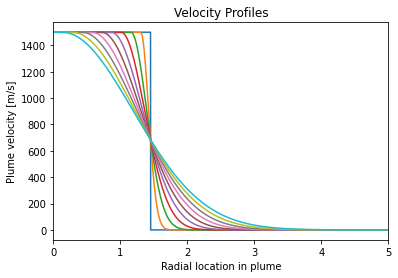

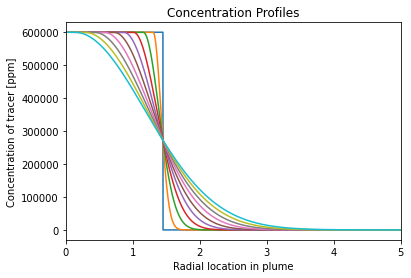

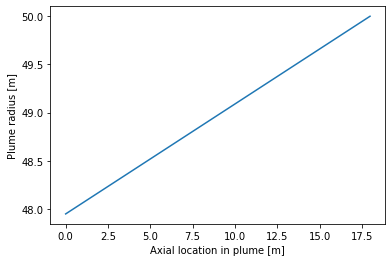

In [34]:
#Plots ZFE
#plot_diffusion(T,r,nx,xmax,'Figure 1')
fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
ax1.set_title("Velocity Profiles")
ax2.set_title("Concentration Profiles")
ax1.set_xlabel("Radial location in plume")
ax2.set_xlabel("Radial location in plume")
ax1.set_ylabel("Plume velocity [m/s]")
ax2.set_ylabel("Concentration of tracer [ppm]")
ax1.set_xlim(0,5)
ax2.set_xlim(0,5)


fig,ax3 = plt.subplots()
ax3.set_xlabel("Axial location in plume [m]")
ax3.set_ylabel("Plume radius [m]")

for i in range(0,nx_ZFE,10):
    ax1.plot(r_ZFE[i,:],u_ZFE[i,:])
    ax2.plot(r_ZFE[i,:],c_ZFE[i,:])
    
ax3.plot(x_ZFE, r_ZFE[:,nr-1]-3.5) # plotting b

#checking that concentration is conserved of tracer
print(np.trapz(u_ZFE[1,:],x=r_ZFE[1,:])/np.trapz(u_ZFE[99,:],x=r_ZFE[99,:]))
print(np.trapz(c_ZFE[1,:],x=r_ZFE[1,:])/np.trapz(c_ZFE[99,:],x=r_ZFE[99,:]))

In [35]:
#Plots ZEF
importlib.reload(ap)
ap.plot_diffusion(T,rT,nx_ZEF,nr,xmax,'Figure 1')
fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
fig, ax3 = plt.subplots()
ax1.set_title("Velocity Profiles")
ax2.set_title("Concentration Profiles")
ax1.set_xlabel("Radial location in plume")
ax2.set_xlabel("Radial location in plume")
ax1.set_ylabel("Plume velocity [m/s]")
ax2.set_ylabel("Concentration of tracer [ppm]")
ax1.set_xlim(3.5,15)
ax2.set_xlim(3.5,15)

for i in range(nx_ZEF-1):
    ax1.plot(r_ZEF[i,:]+3.5,u_ZEF[i,:])

for i in range(nx_ZEF-1):
    ax2.plot(r_ZEF[i,:]+3.5,c_ZEF[i,:])

ax3.plot(x_ZEF, r_ZEF[:, nr-1]-50) # plotting b

#checking that concentration is conserved of tracer

print(np.trapz(u_ZEF[0,:],x=r_ZEF[0,:])/np.trapz(u_ZEF[nx_ZEF-2,:],x=r_ZEF[nx_ZEF-2,:]))
print(np.trapz(c_ZEF[0,:],x=r_ZEF[0,:])/np.trapz(c_ZEF[nx_ZEF-2,:],x=r_ZEF[nx_ZEF-2,:]))

[0.00000000e+00 5.14712190e-04 1.02942438e-03 ... 5.14696748e+01
 5.14701895e+01 5.14707042e+01]
[-2.74428183e+07  2.74432183e+07  0.00000000e+00 ...  0.00000000e+00
  2.74432183e+07  4.00000000e+02]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
### ADDING CANTERA


In [ ]:
mdotAr = np.zeros((nx_ZEF,nr))
mdot_x = np.zeros(nx_ZEF)
rho = 1.69
A = np.zeros((nx_ZEF,nr))
x_ZEF = np.linspace(xmax_ZFE,xmax_ZEF,nx_ZEF)

#for i in range(0, nx_ZEF+nx_ZFE): # loop through axial direction
#    u,c = compute_ZFE()
#    for j in range(0,n_species): # loop through species (concentration of species j at x = i and r = all)
for i in range(nx_ZEF-1):
    for j in range(nr-1):
        #rho = 0.0395*P_atm/(8.314*T[i,j])
        A[i,j] = np.pi*(r_ZEF[i,j+1]**2-r_ZEF[i,j]**2)
        mdotAr[i,j] = c_ZEF[i,j]*u_ZEF[i,j]*rho*A[i,j]/(10**6) #[x,r]
        
np.shape(c_ZEF)
plt.figure()
fig, ax1 = plt.subplots()

mdot_sum = np.zeros(nx_ZEF)

for i in range(nx_ZEF):
    for j in range(nr):
        mdot_sum[i] += mdotAr[i,j]
        
ax1.plot(x_ZEF[0:99],mdot_sum[0:99])

plt.show()